# Local Standard Deviation (LocalSTD) Anomaly Detection for Spacecraft Telemetry

## Algorithm Overview

LocalSTD detects anomalies by analyzing local statistical properties within sliding windows, rather than comparing against global statistics. This approach is particularly effective for:
- Time-series data with changing baselines
- Systems with different operational modes
- Detecting contextual anomalies that might appear normal globally

### Key Points:
1. **Sliding Window**: Examines data in local neighborhoods
2. **Local Statistics**: Computes mean and standard deviation within each window
3. **Adaptive Thresholding**: Anomaly thresholds adapt to local context
4. **Multi-channel Support**: Applies detection across multiple telemetry channels

## Step 1: Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, fbeta_score
)
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Step 2: Load the Space Dataset

The dataset contains telemetry readings from multiple spacecraft channels. Each channel represents different sensor measurements or system parameters. In the localSTD implementation the filenames use x, here we are using the same files.

In [4]:
# Load the datasets
train = pd.read_csv('train_lite.csv')
test = pd.read_csv('test_lite.csv')

# Display basic information
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"\nColumns in dataset:")
print(train.columns.tolist()[:10], "...")  # Show first 10 columns

Training set shape: (88694, 8)
Test set shape: (102554, 7)

Columns in dataset:
['id', 'is_anomaly', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46'] ...


## Step 3: Define the LocalSTD Algorithm

### How LocalSTD Works:

1. **Window Definition**: For each data point, we define a local window of size `window_size`
2. **Local Statistics**: Within each window, we compute:
   - Local mean (μ_local)
   - Local standard deviation (σ_local)
3. **Anomaly Score**: For each point x_i:
   - Score = |x_i - μ_local|/σ_locaσ_local
4. **Thresholding**: Points with scores > threshold are flagged as anomalies

In [5]:
class LocalSTDDetector:
    """
    Local Standard Deviation Anomaly Detector

    This detector identifies anomalies by comparing each point to its local neighborhood
    statistics rather than global statistics.
    """

    def __init__(self, window_size=50, threshold=3.0, min_std=1e-6):
        """
        Parameters:
        -----------
        window_size : int
            Size of the sliding window for local statistics
        threshold : float
            Number of standard deviations from local mean to flag as anomaly
        min_std : float
            Minimum standard deviation to prevent division by zero
        """
        self.window_size = window_size
        self.threshold = threshold
        self.min_std = min_std

    def compute_local_statistics(self, data):
        """
        Compute rolling mean and standard deviation for each channel
        """
        # Calculate rolling statistics with centered window
        rolling_mean = data.rolling(
            window=self.window_size,
            center=True,
            min_periods=1
        ).mean()

        rolling_std = data.rolling(
            window=self.window_size,
            center=True,
            min_periods=1
        ).std()

        # Replace NaN and zero std with minimum value
        rolling_std = rolling_std.fillna(self.min_std)
        rolling_std[rolling_std < self.min_std] = self.min_std

        return rolling_mean, rolling_std

    def compute_anomaly_scores(self, data, rolling_mean, rolling_std):
        """
        Compute z-scores based on local statistics
        """
        z_scores = np.abs((data - rolling_mean) / rolling_std)
        return z_scores

    def detect_anomalies(self, data, channels=None):
        """
        Detect anomalies in the specified channels

        Parameters:
        -----------
        data : pd.DataFrame
            Input data
        channels : list
            List of channel names to analyze

        Returns:
        --------
        anomalies : pd.DataFrame
            Boolean DataFrame indicating anomalies
        scores : pd.DataFrame
            Anomaly scores for each point
        """
        if channels is None:
            channels = [col for col in data.columns if col.startswith('channel_')]

        anomalies = pd.DataFrame(index=data.index)
        scores = pd.DataFrame(index=data.index)

        for channel in channels:
            if channel in data.columns:
                # Compute local statistics
                rolling_mean, rolling_std = self.compute_local_statistics(data[channel])

                # Compute anomaly scores
                channel_scores = self.compute_anomaly_scores(
                    data[channel], rolling_mean, rolling_std
                )

                # Flag anomalies
                channel_anomalies = channel_scores > self.threshold

                anomalies[channel] = channel_anomalies
                scores[channel] = channel_scores

        return anomalies, scores

## Step 4: Apply LocalSTD to Critical Channels

We'll focus on channels 41-46, which appear to be critical telemetry channels based on the reduced dataset.

In [6]:
# Define critical channels to monitor
critical_channels = [f"channel_{i}" for i in range(41, 47)]
print(f"Monitoring channels: {critical_channels}")

# Initialize the detector with optimized parameters
detector = LocalSTDDetector(
    window_size=100,  # Adjust based on expected anomaly duration
    threshold=4.0     # Stricter threshold for space applications
)

Monitoring channels: ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']


## Step 5: Train the Model (Parameter Tuning)

Since we're using an unsupervised method, "training" involves:
1. Analyzing the training data to understand normal behavior
2. Tuning parameters based on the characteristics of the data

In [7]:
# Analyze training data to understand normal behavior
train_subset = train[critical_channels]

# Compute statistics for parameter tuning
train_stats = train_subset.describe()
print("Training Data Statistics:")
print(train_stats.T[['mean', 'std', 'min', 'max']])

Training Data Statistics:
                mean       std       min       max
channel_41  0.813554  0.004718  0.800021  0.823567
channel_42  0.786926  0.006651  0.700000  0.808031
channel_43  0.775277  0.004683  0.763988  0.785352
channel_44  0.799546  0.005690  0.782647  0.815709
channel_45  0.815711  0.005351  0.802440  0.827878
channel_46  0.771487  0.006639  0.749250  0.789786


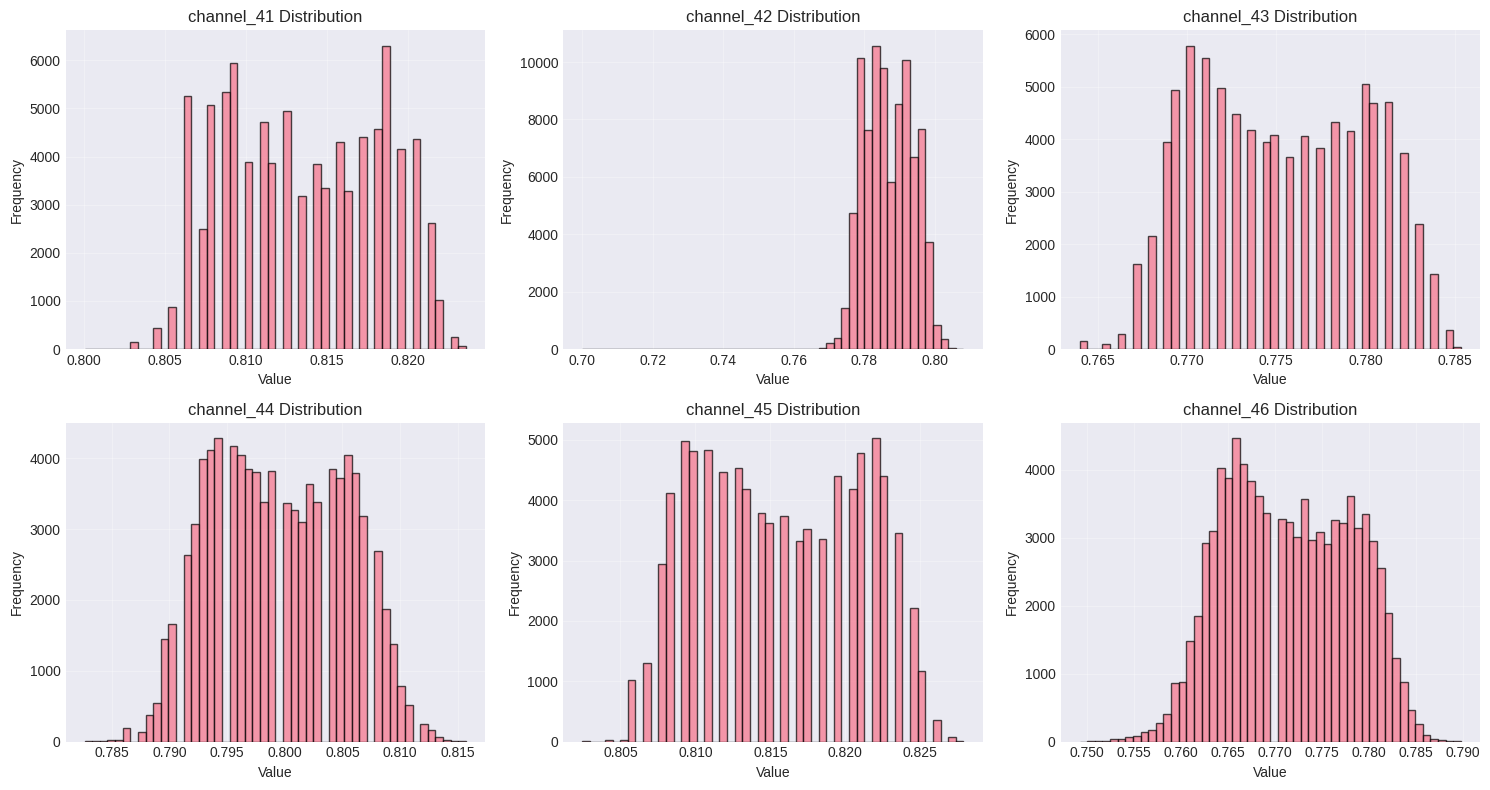

In [8]:
# Visualize the distribution of one channel to understand the data
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, channel in enumerate(critical_channels):
    axes[idx].hist(train[channel].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{channel} Distribution')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Detect Anomalies in Test Data

In [9]:
# Apply LocalSTD detection to test data
test_anomalies, test_scores = detector.detect_anomalies(
    test,
    channels=critical_channels
)

# Aggregate results: flag as anomaly if ANY channel shows anomaly
aggregated_anomalies = test_anomalies.any(axis=1).astype(int)

print(f"Total anomalies detected: {aggregated_anomalies.sum()}")
print(f"Anomaly rate: {aggregated_anomalies.mean():.2%}")
print(f"\nAnomalies per channel:")
print(test_anomalies.sum())

Total anomalies detected: 0
Anomaly rate: 0.00%

Anomalies per channel:
channel_41    0
channel_42    0
channel_43    0
channel_44    0
channel_45    0
channel_46    0
dtype: int64


## Step 7: Visualize Detection Results

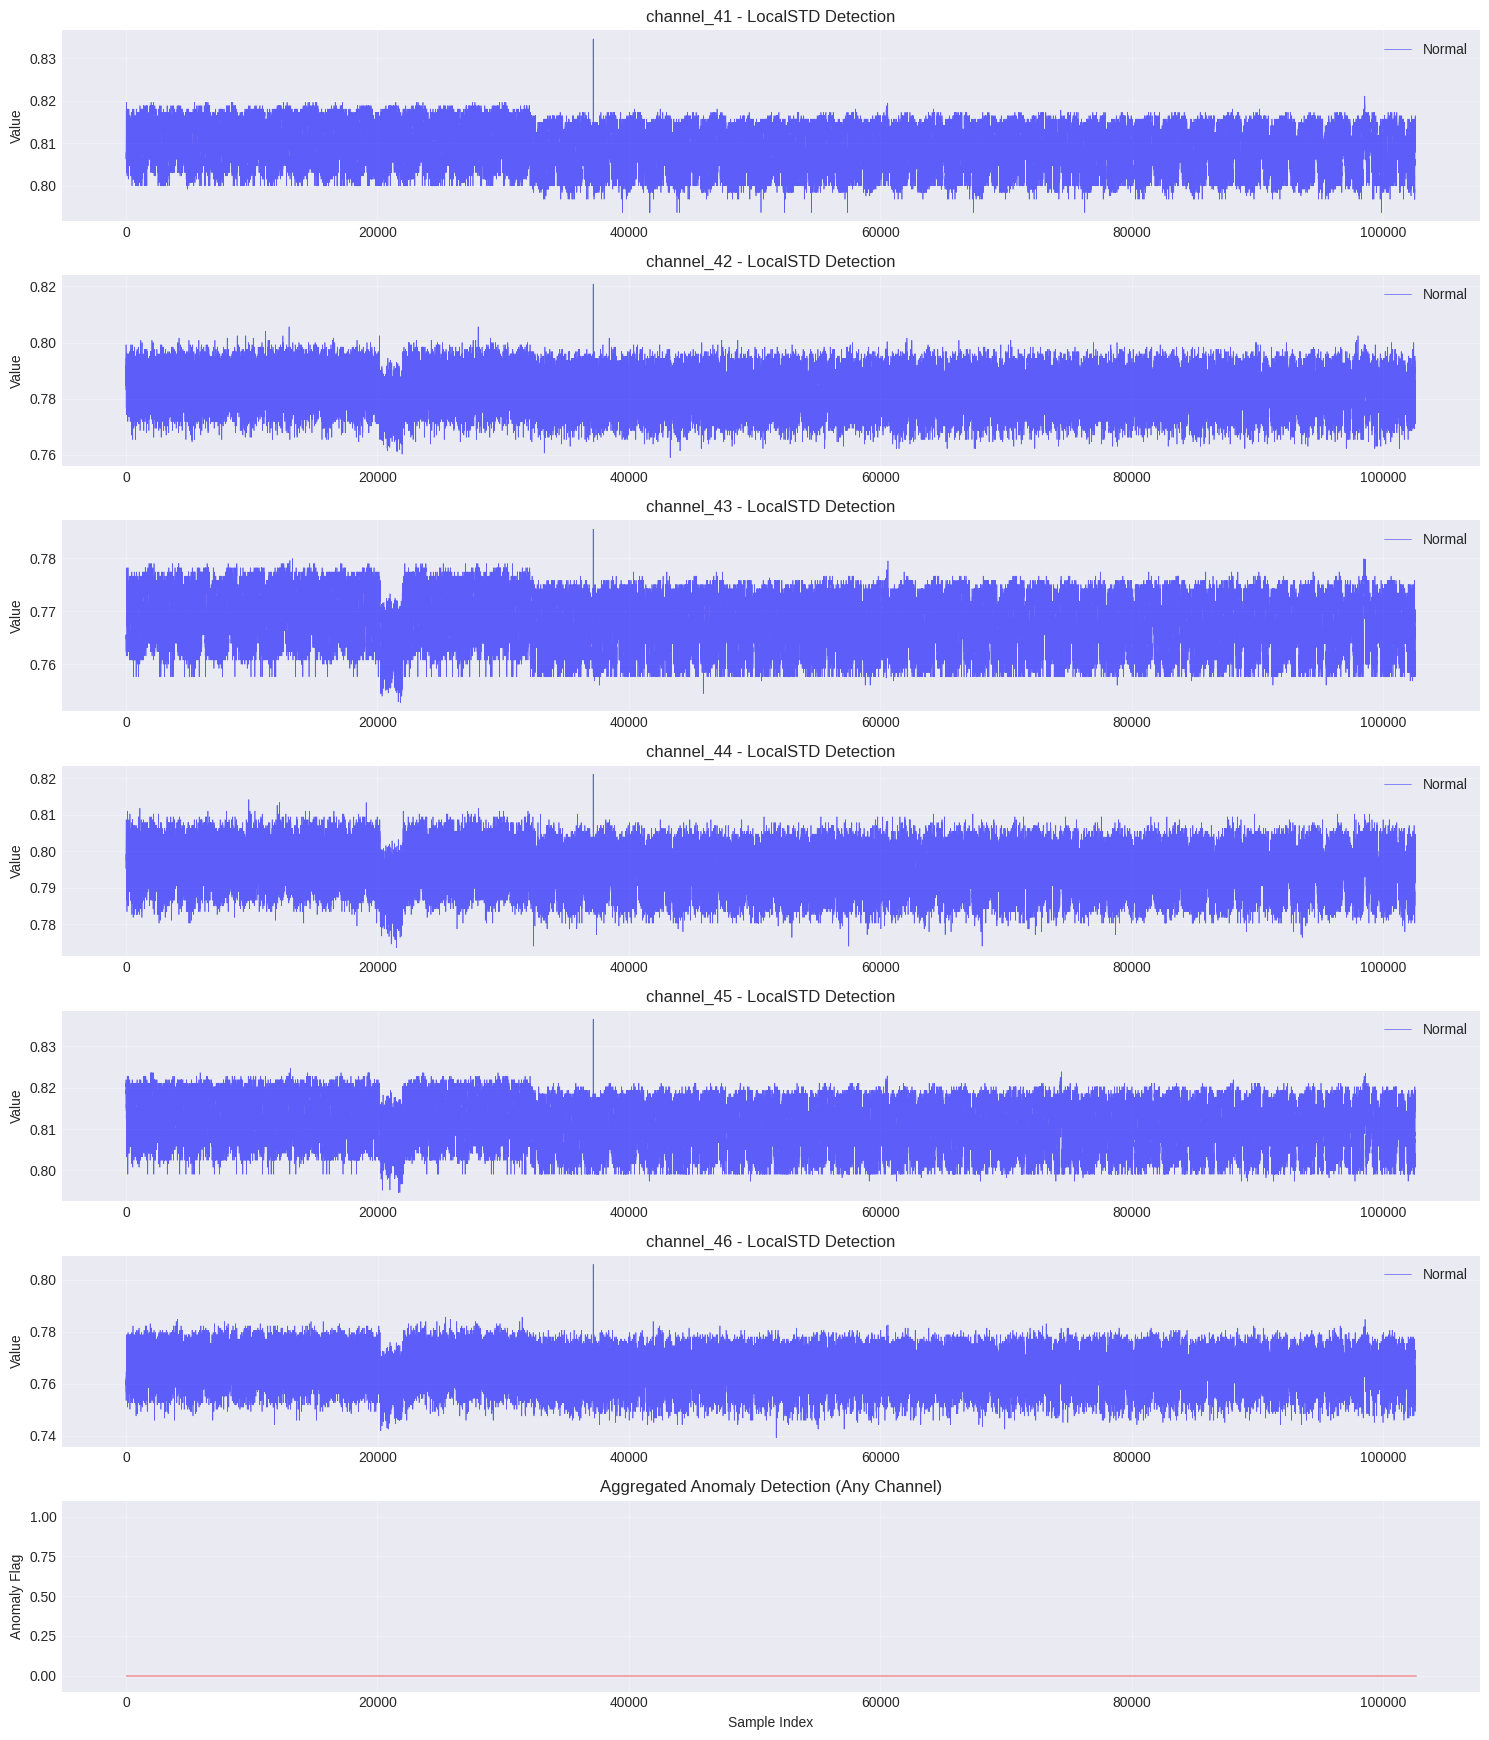

In [10]:
# Plot anomaly detection results over time
fig, axes = plt.subplots(len(critical_channels) + 1, 1,
                         figsize=(15, 2.5 * (len(critical_channels) + 1)))

# Plot each channel with anomalies highlighted
for idx, channel in enumerate(critical_channels):
    ax = axes[idx]

    # Plot normal data
    ax.plot(test.index, test[channel], 'b-', alpha=0.6, linewidth=0.5, label='Normal')

    # Highlight anomalies
    anomaly_mask = test_anomalies[channel]
    if anomaly_mask.any():
        ax.scatter(test.index[anomaly_mask], test[channel][anomaly_mask],
                  c='red', s=10, alpha=0.8, label='Anomaly')

    ax.set_title(f'{channel} - LocalSTD Detection')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Plot aggregated results
axes[-1].fill_between(test.index, 0, aggregated_anomalies,
                      color='red', alpha=0.3, step='mid')
axes[-1].set_title('Aggregated Anomaly Detection (Any Channel)')
axes[-1].set_xlabel('Sample Index')
axes[-1].set_ylabel('Anomaly Flag')
axes[-1].set_ylim(-0.1, 1.1)
axes[-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Analyze Anomaly Scores Distribution

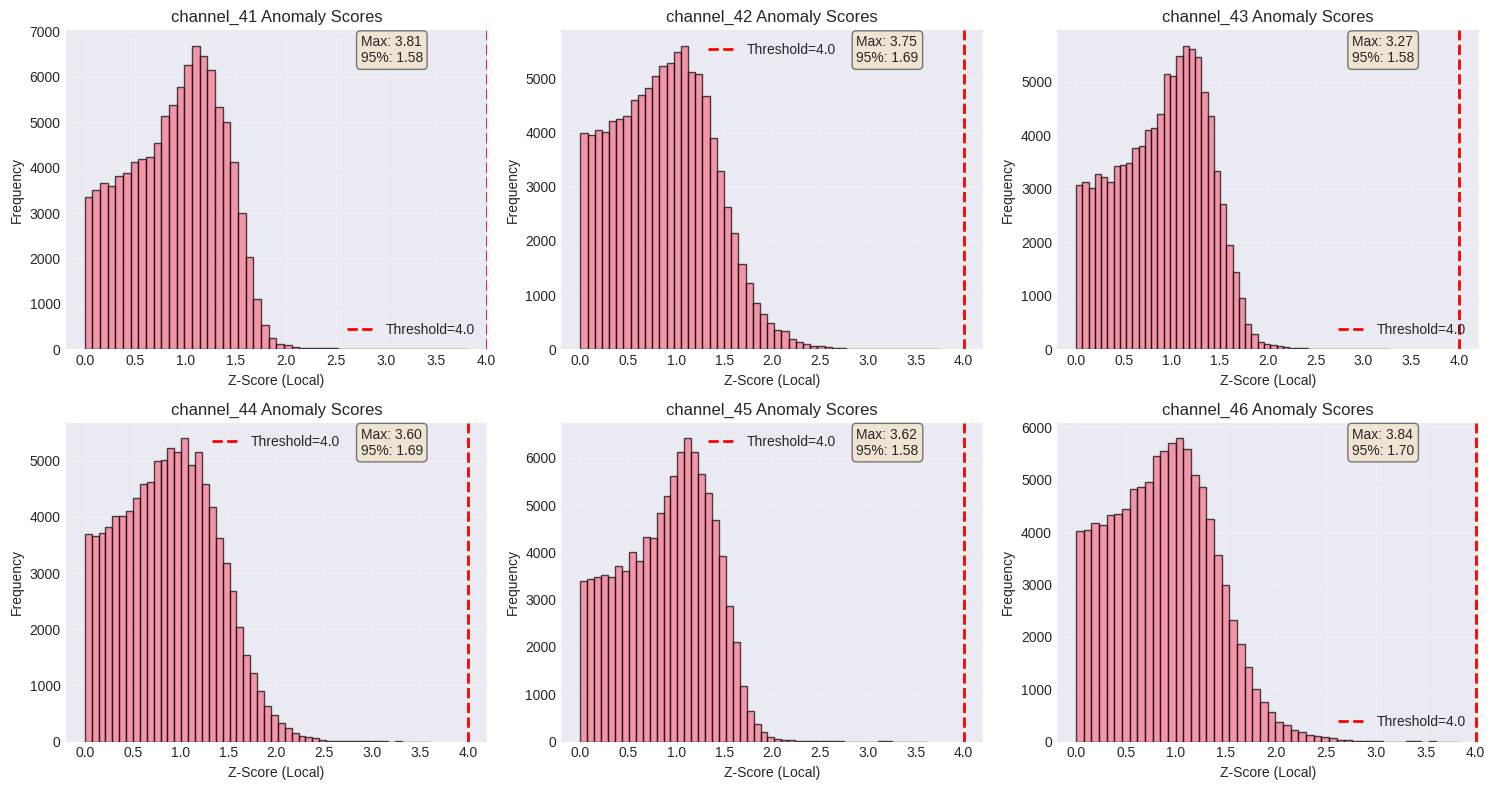

In [11]:
# Plot distribution of anomaly scores
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, channel in enumerate(critical_channels):
    scores = test_scores[channel]

    axes[idx].hist(scores, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(detector.threshold, color='red', linestyle='--',
                     linewidth=2, label=f'Threshold={detector.threshold}')
    axes[idx].set_title(f'{channel} Anomaly Scores')
    axes[idx].set_xlabel('Z-Score (Local)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

    # Add statistics text
    stats_text = f'Max: {scores.max():.2f}\n95%: {scores.quantile(0.95):.2f}'
    axes[idx].text(0.7, 0.9, stats_text, transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Step 9: Parameter Sensitivity Analysis

Understanding how different parameters affect detection performance is crucial for deployment.

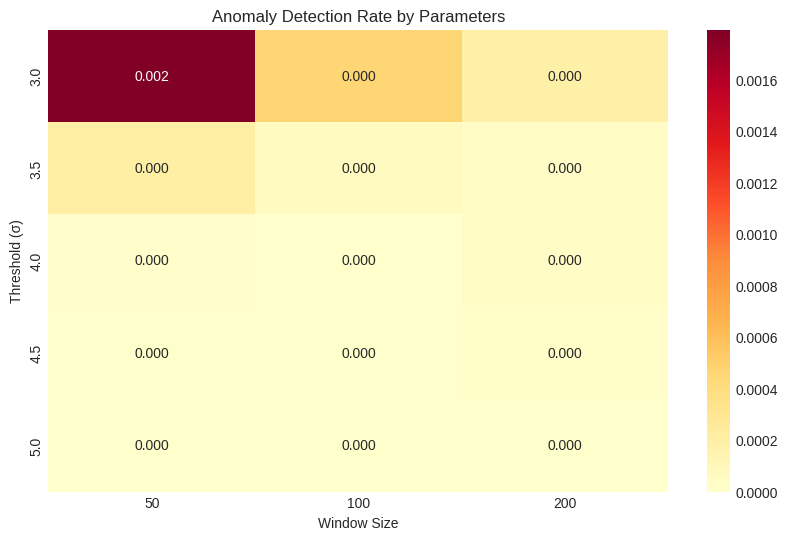

In [13]:
# Test different parameter combinations
window_sizes = [50, 100, 200]
thresholds = [3.0, 3.5, 4.0, 4.5, 5.0]

results = []

for window in window_sizes:
    for thresh in thresholds:
        # Create detector with current parameters
        temp_detector = LocalSTDDetector(window_size=window, threshold=thresh)

        # Detect anomalies
        temp_anomalies, _ = temp_detector.detect_anomalies(test, channels=critical_channels)
        temp_aggregated = temp_anomalies.any(axis=1).astype(int)

        # Store results
        results.append({
            'window_size': window,
            'threshold': thresh,
            'anomaly_count': temp_aggregated.sum(),
            'anomaly_rate': temp_aggregated.mean()
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Pivot for heatmap
pivot_table = results_df.pivot(index='threshold', columns='window_size', values='anomaly_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Anomaly Detection Rate by Parameters')
plt.xlabel('Window Size')
plt.ylabel('Threshold (σ)')
plt.show()

##Generate Submission File as csv

In [14]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test['id'],
    'is_anomaly': aggregated_anomalies
})

# Save to CSV
submission_df.to_csv('localstd_submission.csv', index=False)
print(f"Submission file saved: localstd_submission.csv")
print(f"Shape: {submission_df.shape}")
print(f"\nFirst 10 rows:")
print(submission_df.head(10))

Submission file saved: localstd_submission.csv
Shape: (102554, 2)

First 10 rows:
         id  is_anomaly
0  14728321           0
1  14728322           0
2  14728323           0
3  14728324           0
4  14728325           0
5  14728326           0
6  14728327           0
7  14728328           0
8  14728329           0
9  14728330           0


## Quick Summary:

**LocalSTD Advantages:**
- Adapts to changing baselines in the data
- Better at detecting contextual anomalies
- More robust to concept drift
- Suitable for non-stationary time series

For spacecraft telemetry:
1. LocalSTD should be used when:
   - Spacecraft operates in different modes (launch, cruise, orbit)
   - Environmental conditions change (eclipse, solar radiation)
   - Gradual degradation needs to be distinguished from sudden faults

2. **Key Points:**
   - Window size should match expected anomaly duration
   - Threshold tuning is critical for balancing false positives/negatives
   - Multi-channel aggregation strategy affects overall sensitivity

### To keep in mind for statistical accuracy:
- Start with window_size = 100 and threshold = 4.0
- Monitor critical channels more strictly
- Implement alert prioritization based on anomaly scores